In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# 1. Veri Setini Yükleme
file_path = "/content/Gerçek Veri Seti_tr.xlsx"  # Dosya yolu
data = pd.read_excel(file_path)

# Veri seti sütun adları kontrol
print("Veri seti sütun adları:", data.columns)

# 2. Veri Kaynaklarını Ayırma
X = data["Text"].dropna().astype(str).tolist()  # Mesajlar (text)
y = data["Label"].dropna().astype(int).tolist()  # Etiketler (label)

# 3. Veri Temsili
print("Veri temsili oluşturuluyor...")
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

# BoW (Bag of Words)
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(X)

# Word2Vec
X_words = [text.lower().split() for text in X]
w2v_model = Word2Vec(sentences=X_words, vector_size=100, window=5, min_count=2, sg=1)

def get_average_w2v(text, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

X_w2v = np.array([get_average_w2v(text, w2v_model, 100) for text in X_words])

# LSTM için Tokenizer ve padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=500)

# 4. Veri Ayrımı
print("Veri eğitim ve test setine ayrılıyor...")
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bow, X_test_bow, _, _ = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_lstm, X_test_lstm, _, _ = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# 5. Sınıflandırıcılar ve LSTM Modeli
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 sınıf: Spam ve Non-Spam
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. Model Eğitim ve Değerlendirme
results = {}

# Diğer sınıflandırıcılar
for name, clf in classifiers.items():
    print(f"{name} modeli eğitiliyor...")
    if name == "KNN":
        X_train, X_test = X_train_w2v, X_test_w2v
    elif name == "SVM":
        X_train, X_test = X_train_bow, X_test_bow
    else:
        X_train, X_test = X_train_tfidf, X_test_tfidf
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1 Score": f1}
    print(f"{name} - Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# LSTM Modeli Eğitimi
print("LSTM modeli eğitiliyor...")
# Verilerin doğru formatta olduğunu kontrol et ve gerekirse dönüştür
X_train_lstm = np.array(X_train_lstm)  # NumPy dizisine dönüştür
y_train = np.array(y_train)  # NumPy dizisine dönüştür

lstm_model.fit(X_train_lstm, y_train, epochs=3, batch_size=32, validation_split=0.2)
y_pred_lstm = lstm_model.predict(X_test_lstm).argmax(axis=1)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')
results["LSTM"] = {"Accuracy": acc_lstm, "Precision": precision_lstm, "Recall": recall_lstm, "F1 Score": f1_lstm}
print(f"LSTM - Accuracy: {acc_lstm:.2f}, Precision: {precision_lstm:.2f}, Recall: {recall_lstm:.2f}, F1 Score: {f1_lstm:.2f}")

# Sonuçları Görselleştirme
df_results = pd.DataFrame(results).T
df_results.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange', 'green', 'red'])
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Skor")
plt.show()

# 7. 10 Katlı Çapraz Doğrulama
print("10 Katlı Çapraz Doğrulama uygulanıyor...")
cv_results = {}
for name, clf in classifiers.items():
    if name == "KNN":
        X_train = X_train_w2v
    elif name == "SVM":
        X_train = X_train_bow
    else:
        X_train = X_train_tfidf
    cv_score = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    cv_results[name] = np.mean(cv_score)
    print(f"{name} - Cross-Validation Accuracy: {cv_results[name]:.2f}")


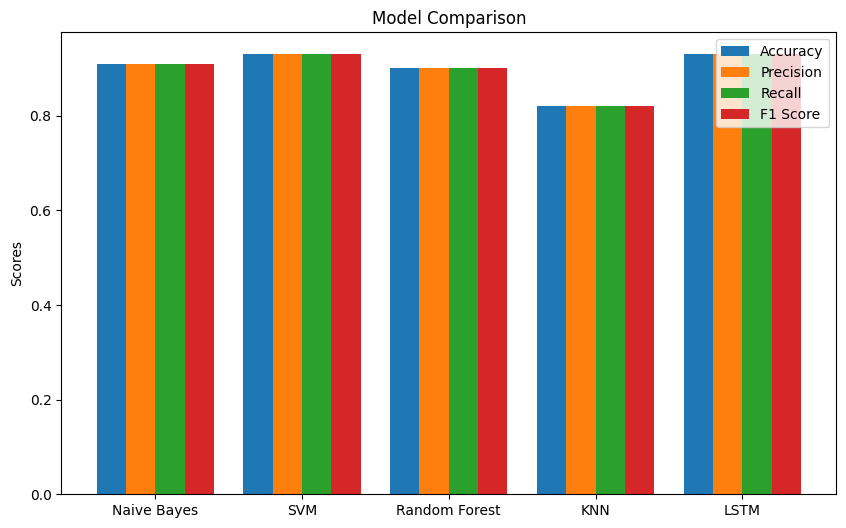

In [ ]:
import matplotlib.pyplot as plt

models = ['Naive Bayes', 'SVM', 'Random Forest', 'KNN', 'LSTM']
accuracy = [0.91, 0.93, 0.90, 0.82, 0.93]
precision = [0.91, 0.93, 0.90, 0.82, 0.93]
recall = [0.91, 0.93, 0.90, 0.82, 0.93]
f1_score = [0.91, 0.93, 0.90, 0.82, 0.93]

# Plotting the bar chart
x = range(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, accuracy, width, label='Accuracy')
ax.bar([p + width for p in x], precision, width, label='Precision')
ax.bar([p + width * 2 for p in x], recall, width, label='Recall')
ax.bar([p + width * 3 for p in x], f1_score, width, label='F1 Score')

ax.set_xticks([p + 1.5 * width for p in x])
ax.set_xticklabels(models)
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')

ax.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Dosya yolunu belirtme
file_path = '/content/Gerçek Veri Seti_tr.xlsx'

# Excel dosyasını okuma
data = pd.read_excel(file_path)

# Dosya içeriğini kontrol etme
print(data.head())


                                                Text  Label
0   Bizi takip edin ve başarı hikayelerimizi izle...      1
1   Fiyatlarımızda yapılan düzenlemeler hakkında ...      1
2   Kişisel gelişim yolculuğunuzda sizi destekliy...      1
3   Yolculuğunuzda daha hızlı ilerlemeniz için ye...      1
4  [Ad], bültenimize abone olduğunuz için teşekkü...      1


In [ ]:
# Veri hazırlığı
X = data["Text"].dropna().astype(str).tolist()  # Text mesajları
y = data["Label"].dropna().astype(int).tolist()  # Etiketler (Spam veya Non-Spam)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# TF-IDF ile veri temsili
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Eğitim ve test verilerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Naive Bayes modeli
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Modeli değerlendirme
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")


Accuracy: 0.91


In [ ]:
# Sonuçları kaydetme
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results.to_csv('/content/drive/My Drive/sonuc.csv', index=False)

print("Sonuçlar Google Drive'a kaydedildi.")


Sonuçlar Google Drive'a kaydedildi.


Veri seti sütun adları: Index(['Text', 'Label'], dtype='object')
Veri temsili oluşturuluyor...
Veri eğitim ve test setine ayrılıyor...
Naive Bayes modeli eğitiliyor...
Naive Bayes - Accuracy: 0.90, Precision: 0.90, Recall: 0.90, F1 Score: 0.90
SVM modeli eğitiliyor...
SVM - Accuracy: 0.93, Precision: 0.93, Recall: 0.93, F1 Score: 0.93
Random Forest modeli eğitiliyor...
Random Forest - Accuracy: 0.91, Precision: 0.91, Recall: 0.91, F1 Score: 0.91
KNN modeli eğitiliyor...
KNN - Accuracy: 0.82, Precision: 0.83, Recall: 0.82, F1 Score: 0.82
LSTM modeli eğitiliyor...
Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.6730 - loss: 0.6454 - val_accuracy: 0.8781 - val_loss: 0.3077
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - accuracy: 0.9446 - loss: 0.1548 - val_accuracy: 0.9187 - val_loss: 0.2659
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 632ms/step - accuracy: 0.9718 - loss: 0.0609 - val_accuracy: 0.9187 - val_loss: 0.2937
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
LSTM -

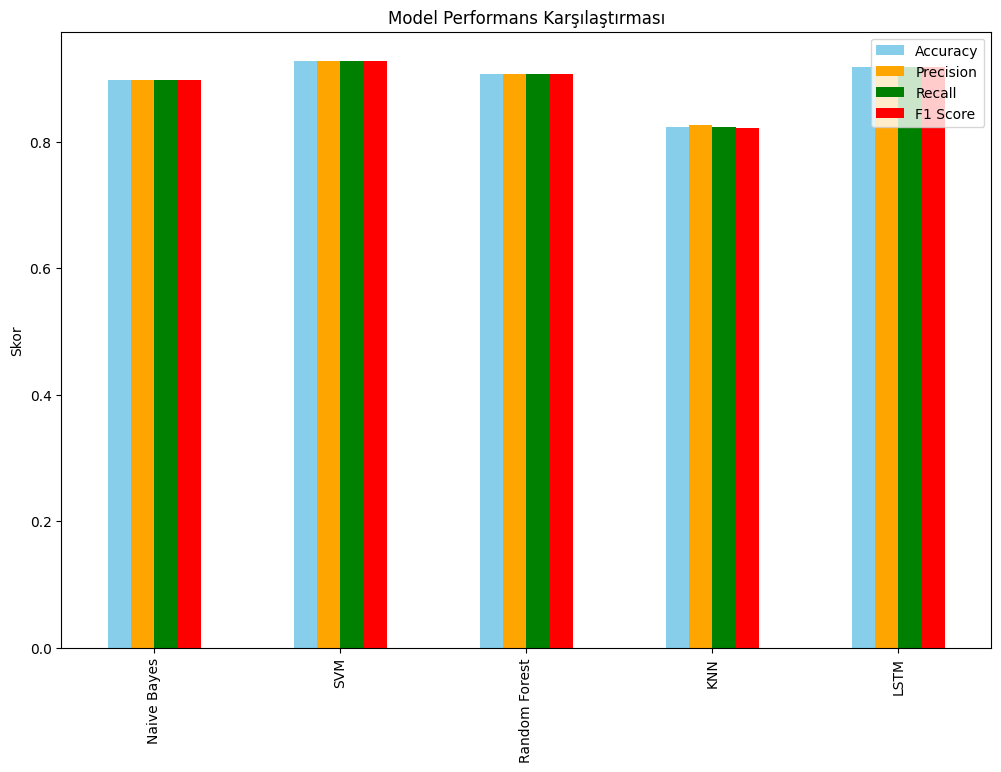

10 Katlı Çapraz Doğrulama uygulanıyor...
Naive Bayes - Cross-Validation Accuracy: 0.92
SVM - Cross-Validation Accuracy: 0.92
Random Forest - Cross-Validation Accuracy: 0.90
KNN - Cross-Validation Accuracy: 0.85


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# 1. Veri Setini Yükleme
file_path = "/content/Gerçek Veri Seti_ing.xlsx"  # Dosya yolunu belirleyin
data = pd.read_excel(file_path)

# Veri seti sütun adlarını kontrol edin
print("Veri seti sütun adları:", data.columns)

# 2. Veri Kaynaklarını Ayırma
X = data["Text"].dropna().astype(str).tolist()  # Mesajlar (text)
y = data["Label"].dropna().astype(int).tolist()  # Etiketler (label)

# 3. Veri Temsili
print("Veri temsili oluşturuluyor...")
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

# BoW (Bag of Words)
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(X)

# Word2Vec
X_words = [text.lower().split() for text in X]
w2v_model = Word2Vec(sentences=X_words, vector_size=100, window=5, min_count=2, sg=1)

def get_average_w2v(text, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

X_w2v = np.array([get_average_w2v(text, w2v_model, 100) for text in X_words])

# LSTM için Tokenizer ve padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=500)

# 4. Veri Ayrımı
print("Veri eğitim ve test setine ayrılıyor...")
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bow, X_test_bow, _, _ = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_lstm, X_test_lstm, _, _ = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# 5. Sınıflandırıcılar ve LSTM Modeli
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 sınıf: Spam ve Non-Spam
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. Model Eğitim ve Değerlendirme
results = {}

# Diğer sınıflandırıcılar
for name, clf in classifiers.items():
    print(f"{name} modeli eğitiliyor...")
    if name == "KNN":
        X_train, X_test = X_train_w2v, X_test_w2v
    elif name == "SVM":
        X_train, X_test = X_train_bow, X_test_bow
    else:
        X_train, X_test = X_train_tfidf, X_test_tfidf
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1 Score": f1}
    print(f"{name} - Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# LSTM Modeli Eğitimi
print("LSTM modeli eğitiliyor...")
# Verilerin doğru formatta olduğunu kontrol et ve gerekirse dönüştür
X_train_lstm = np.array(X_train_lstm)  # NumPy dizisine dönüştür
y_train = np.array(y_train)  # NumPy dizisine dönüştür

lstm_model.fit(X_train_lstm, y_train, epochs=3, batch_size=32, validation_split=0.2)
y_pred_lstm = lstm_model.predict(X_test_lstm).argmax(axis=1)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')
results["LSTM"] = {"Accuracy": acc_lstm, "Precision": precision_lstm, "Recall": recall_lstm, "F1 Score": f1_lstm}
print(f"LSTM - Accuracy: {acc_lstm:.2f}, Precision: {precision_lstm:.2f}, Recall: {recall_lstm:.2f}, F1 Score: {f1_lstm:.2f}")

# Sonuçları Görselleştirme
df_results = pd.DataFrame(results).T
df_results.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange', 'green', 'red'])
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Skor")
plt.show()

# 7. 10 Katlı Çapraz Doğrulama
print("10 Katlı Çapraz Doğrulama uygulanıyor...")
cv_results = {}
for name, clf in classifiers.items():
    if name == "KNN":
        X_train = X_train_w2v
    elif name == "SVM":
        X_train = X_train_bow
    else:
        X_train = X_train_tfidf
    cv_score = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    cv_results[name] = np.mean(cv_score)
    print(f"{name} - Cross-Validation Accuracy: {cv_results[name]:.2f}")


Veri seti sütun adları: Index(['Text', 'Label'], dtype='object')
Veri temsili oluşturuluyor...
Veri eğitim ve test setine ayrılıyor...
Naive Bayes modeli eğitiliyor...
Naive Bayes - Accuracy: 0.91, Precision: 0.92, Recall: 0.91, F1 Score: 0.91
SVM modeli eğitiliyor...
SVM - Accuracy: 0.91, Precision: 0.91, Recall: 0.91, F1 Score: 0.91
Random Forest modeli eğitiliyor...
Random Forest - Accuracy: 0.91, Precision: 0.91, Recall: 0.91, F1 Score: 0.91
KNN modeli eğitiliyor...
KNN - Accuracy: 0.82, Precision: 0.83, Recall: 0.82, F1 Score: 0.82
LSTM modeli eğitiliyor...
Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 512ms/step - accuracy: 0.5502 - loss: 0.6767 - val_accuracy: 0.7094 - val_loss: 0.5648
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 515ms/step - accuracy: 0.8833 - loss: 0.2779 - val_accuracy: 0.9062 - val_loss: 0.2688
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 554ms/step - accuracy: 0.9681 - loss: 0.0796 - val_accuracy: 0.9156 - val_loss: 0.2271
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
LSTM -

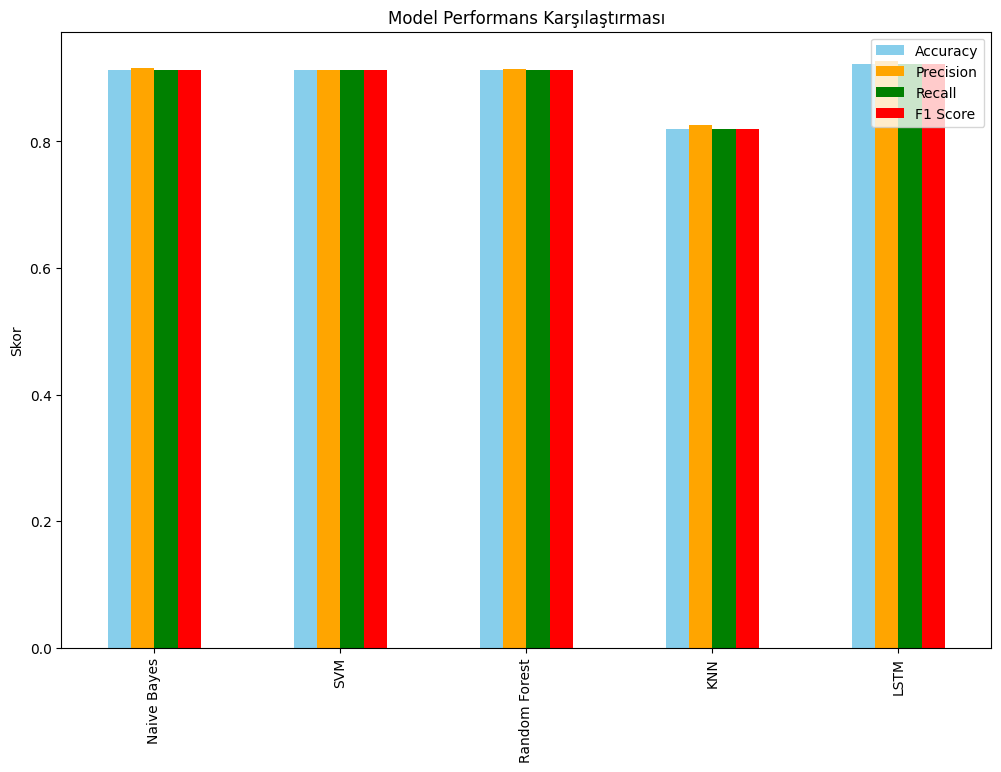

10 Katlı Çapraz Doğrulama uygulanıyor...
Naive Bayes - Cross-Validation Accuracy: 0.91
SVM - Cross-Validation Accuracy: 0.91
Random Forest - Cross-Validation Accuracy: 0.90
KNN - Cross-Validation Accuracy: 0.81


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# 1. Veri Setini Yükleme
file_path = "/content/LLM_Data.xlsx"  # Dosya yolunu belirleyin
data = pd.read_excel(file_path)

# Veri seti sütun adlarını kontrol edin
print("Veri seti sütun adları:", data.columns)

# 2. Veri Kaynaklarını Ayırma
X = data["Text"].dropna().astype(str).tolist()  # Mesajlar (text)
y = data["Label"].dropna().astype(int).tolist()  # Etiketler (label)

# 3. Veri Temsili
print("Veri temsili oluşturuluyor...")
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

# BoW (Bag of Words)
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(X)

# Word2Vec
X_words = [text.lower().split() for text in X]
w2v_model = Word2Vec(sentences=X_words, vector_size=100, window=5, min_count=2, sg=1)

def get_average_w2v(text, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

X_w2v = np.array([get_average_w2v(text, w2v_model, 100) for text in X_words])

# LSTM için Tokenizer ve padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=500)

# 4. Veri Ayrımı
print("Veri eğitim ve test setine ayrılıyor...")
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bow, X_test_bow, _, _ = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_lstm, X_test_lstm, _, _ = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# 5. Sınıflandırıcılar ve LSTM Modeli
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 sınıf: Spam ve Non-Spam
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. Model Eğitim ve Değerlendirme
results = {}

# Diğer sınıflandırıcılar
for name, clf in classifiers.items():
    print(f"{name} modeli eğitiliyor...")
    if name == "KNN":
        X_train, X_test = X_train_w2v, X_test_w2v
    elif name == "SVM":
        X_train, X_test = X_train_bow, X_test_bow
    else:
        X_train, X_test = X_train_tfidf, X_test_tfidf
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1 Score": f1}
    print(f"{name} - Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# LSTM Modeli Eğitimi
print("LSTM modeli eğitiliyor...")
# Verilerin doğru formatta olduğunu kontrol et ve gerekirse dönüştür
X_train_lstm = np.array(X_train_lstm)  # NumPy dizisine dönüştür
y_train = np.array(y_train)  # NumPy dizisine dönüştür

lstm_model.fit(X_train_lstm, y_train, epochs=3, batch_size=32, validation_split=0.2)
y_pred_lstm = lstm_model.predict(X_test_lstm).argmax(axis=1)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')
results["LSTM"] = {"Accuracy": acc_lstm, "Precision": precision_lstm, "Recall": recall_lstm, "F1 Score": f1_lstm}
print(f"LSTM - Accuracy: {acc_lstm:.2f}, Precision: {precision_lstm:.2f}, Recall: {recall_lstm:.2f}, F1 Score: {f1_lstm:.2f}")

# Sonuçları Görselleştirme
df_results = pd.DataFrame(results).T
df_results.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange', 'green', 'red'])
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Skor")
plt.show()

# 7. 10 Katlı Çapraz Doğrulama
print("10 Katlı Çapraz Doğrulama uygulanıyor...")
cv_results = {}
for name, clf in classifiers.items():
    if name == "KNN":
        X_train = X_train_w2v
    elif name == "SVM":
        X_train = X_train_bow
    else:
        X_train = X_train_tfidf
    cv_score = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    cv_results[name] = np.mean(cv_score)
    print(f"{name} - Cross-Validation Accuracy: {cv_results[name]:.2f}")


In [ ]:
import numpy as np

y = np.array(y)  # Listeyi numpy dizisine dönüştürme
print("X_tfidf shape:", X_tfidf.shape)
print("y shape:", y.shape)


X_tfidf shape: (4000, 5000)
y shape: (3000,)


In [ ]:
# Boyutları kontrol et
if X_tfidf.shape[0] != len(y):
    print(f"X_tfidf samples: {X_tfidf.shape[0]}, y samples: {len(y)}")
    min_len = min(X_tfidf.shape[0], len(y))
    X_tfidf = X_tfidf[:min_len]
    y = y[:min_len]
    print("Boyutlar eşitlendi.")

# Eğitim ve test setine ayır
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print("Veri başarıyla ayrıldı.")


X_tfidf samples: 4000, y samples: 3000
Boyutlar eşitlendi.
Veri başarıyla ayrıldı.


In [ ]:
# Boyutları kontrol et
if X_tfidf.shape[0] != len(y):
    print(f"X_tfidf samples: {X_tfidf.shape[0]}, y samples: {len(y)}")
    min_len = min(X_tfidf.shape[0], len(y))
    X_tfidf = X_tfidf[:min_len]
    y = y[:min_len]
    print("Boyutlar eşitlendi.")

# Eğitim ve test setine ayır
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print("Veri başarıyla ayrıldı.")


Veri başarıyla ayrıldı.


Veri seti sütun adları: Index(['Text', 'Label'], dtype='object')
Veri temsili oluşturuluyor...
Veri eğitim ve test setine ayrılıyor...
Naive Bayes modeli eğitiliyor...
Naive Bayes - Accuracy: 0.88, Precision: 0.88, Recall: 0.88, F1 Score: 0.88
SVM modeli eğitiliyor...
SVM - Accuracy: 0.89, Precision: 0.89, Recall: 0.89, F1 Score: 0.89
Random Forest modeli eğitiliyor...
Random Forest - Accuracy: 0.88, Precision: 0.88, Recall: 0.88, F1 Score: 0.88
KNN modeli eğitiliyor...
KNN - Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1 Score: 0.78
LSTM modeli eğitiliyor...
Epoch 1/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 627ms/step - accuracy: 0.6373 - loss: 0.6129 - val_accuracy: 0.9031 - val_loss: 0.2304
Epoch 2/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 51s 638ms/step - accuracy: 0.9345 - loss: 0.1766 - val_accuracy: 0.9172 - val_loss: 0.1982
Epoch 3/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 627ms/step - accuracy: 0.9833 - loss: 0.0610 - val_accuracy: 0.9031 - val_loss: 0.2359
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step
LSTM -

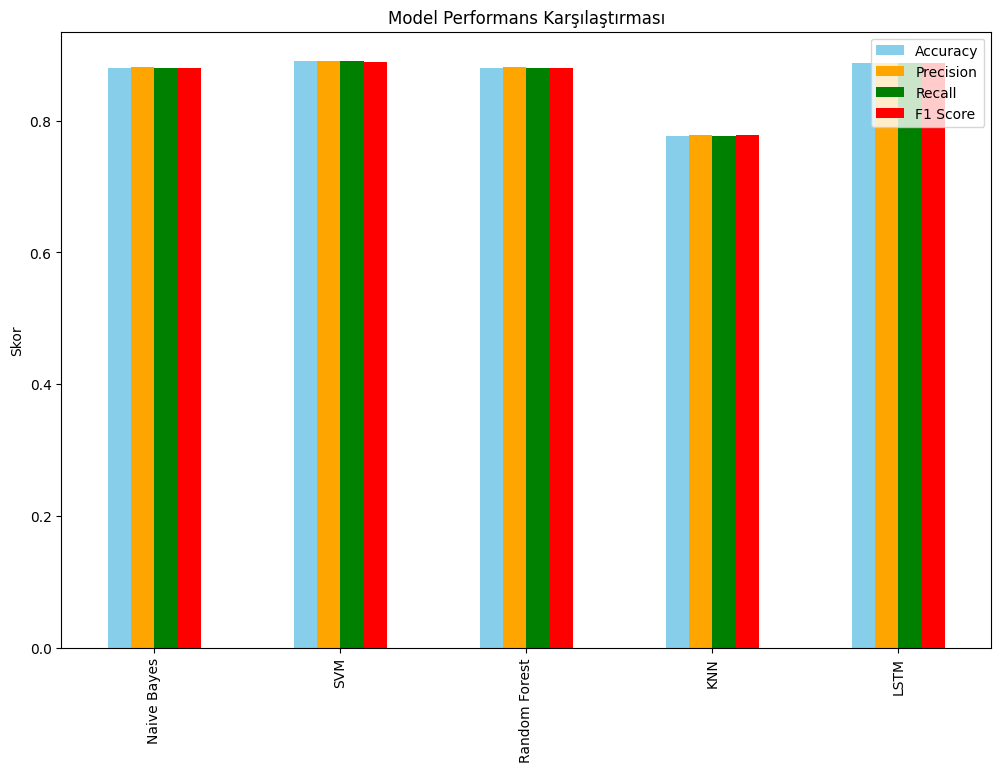

10 Katlı Çapraz Doğrulama uygulanıyor...
Naive Bayes - Cross-Validation Accuracy: 0.88
SVM - Cross-Validation Accuracy: 0.88
Random Forest - Cross-Validation Accuracy: 0.89
KNN - Cross-Validation Accuracy: 0.81


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# 1. Veri Setini Yükleme
file_path = "/content/Birleşik_Data (1).xlsx"  # Dosya yolunu belirleyin
data = pd.read_excel(file_path)

# Veri seti sütun adlarını kontrol edin
print("Veri seti sütun adları:", data.columns)

# 2. Veri Kaynaklarını Ayırma
X = data["Text"].dropna().astype(str).tolist()  # Mesajlar (text)
y = data["Label"].dropna().astype(int).tolist()  # Etiketler (label)

# 3. Veri Temsili
print("Veri temsili oluşturuluyor...")
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

# BoW (Bag of Words)
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(X)

# Word2Vec
X_words = [text.lower().split() for text in X]
w2v_model = Word2Vec(sentences=X_words, vector_size=100, window=5, min_count=2, sg=1)

def get_average_w2v(text, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

X_w2v = np.array([get_average_w2v(text, w2v_model, 100) for text in X_words])

# LSTM için Tokenizer ve padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=500)

# 4. Veri Ayrımı
print("Veri eğitim ve test setine ayrılıyor...")
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bow, X_test_bow, _, _ = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_lstm, X_test_lstm, _, _ = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# 5. Sınıflandırıcılar ve LSTM Modeli
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 sınıf: Spam ve Non-Spam
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. Model Eğitim ve Değerlendirme
results = {}

# Diğer sınıflandırıcılar
for name, clf in classifiers.items():
    print(f"{name} modeli eğitiliyor...")
    if name == "KNN":
        X_train, X_test = X_train_w2v, X_test_w2v
    elif name == "SVM":
        X_train, X_test = X_train_bow, X_test_bow
    else:
        X_train, X_test = X_train_tfidf, X_test_tfidf
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1 Score": f1}
    print(f"{name} - Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# LSTM Modeli Eğitimi
print("LSTM modeli eğitiliyor...")
# Verilerin doğru formatta olduğunu kontrol et ve gerekirse dönüştür
X_train_lstm = np.array(X_train_lstm)  # NumPy dizisine dönüştür
y_train = np.array(y_train)  # NumPy dizisine dönüştür

lstm_model.fit(X_train_lstm, y_train, epochs=3, batch_size=32, validation_split=0.2)
y_pred_lstm = lstm_model.predict(X_test_lstm).argmax(axis=1)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')
results["LSTM"] = {"Accuracy": acc_lstm, "Precision": precision_lstm, "Recall": recall_lstm, "F1 Score": f1_lstm}
print(f"LSTM - Accuracy: {acc_lstm:.2f}, Precision: {precision_lstm:.2f}, Recall: {recall_lstm:.2f}, F1 Score: {f1_lstm:.2f}")

# Sonuçları Görselleştirme
df_results = pd.DataFrame(results).T
df_results.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange', 'green', 'red'])
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Skor")
plt.show()

# 7. 10 Katlı Çapraz Doğrulama
print("10 Katlı Çapraz Doğrulama uygulanıyor...")
cv_results = {}
for name, clf in classifiers.items():
    if name == "KNN":
        X_train = X_train_w2v
    elif name == "SVM":
        X_train = X_train_bow
    else:
        X_train = X_train_tfidf
    cv_score = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    cv_results[name] = np.mean(cv_score)
    print(f"{name} - Cross-Validation Accuracy: {cv_results[name]:.2f}")


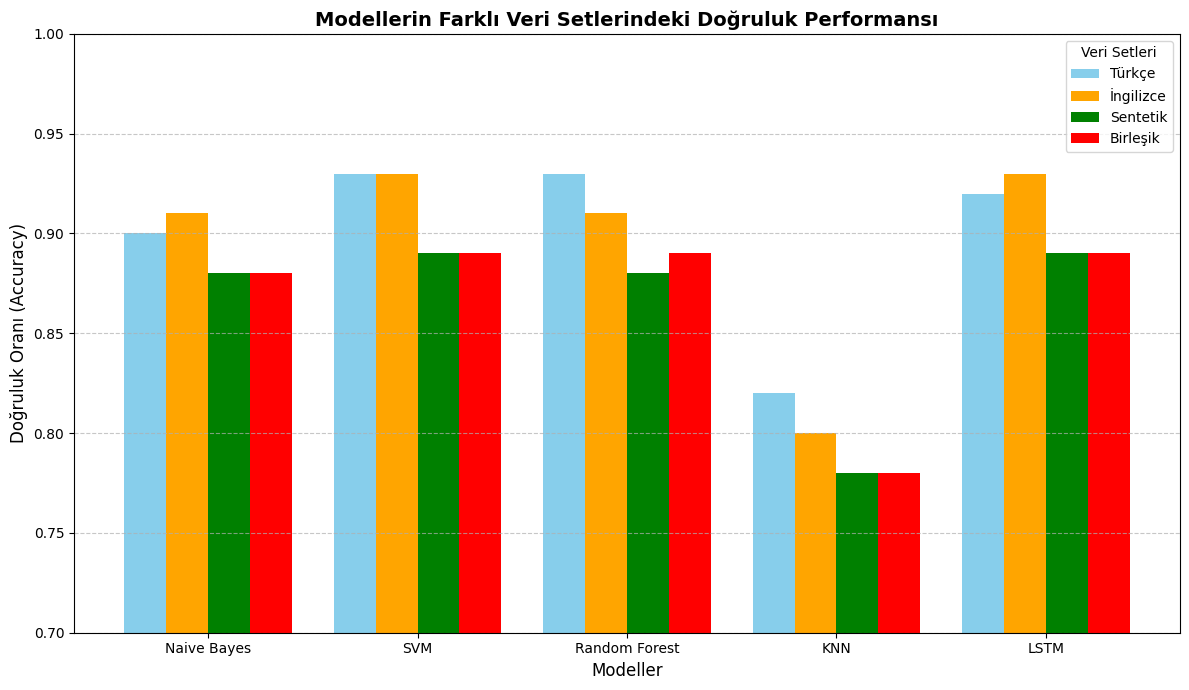

In [5]:
import matplotlib.pyplot as plt # Adding the import statement for matplotlib.pyplot

# Düzeltme: accuracy_scores verilerinin sırasını ve boyutunu doğru eşlemek için düzenlenmesi.
accuracy_scores_fixed = [
    [0.90, 0.93, 0.93, 0.82, 0.92],  # Türkçe
    [0.91, 0.93, 0.91, 0.80, 0.93],  # İngilizce
    [0.88, 0.89, 0.88, 0.78, 0.89],  # Sentetik
    [0.88, 0.89, 0.89, 0.78, 0.89]   # Birleşik
]

# Defining the models and datasets list
models = ['Naive Bayes', 'SVM', 'Random Forest', 'KNN', 'LSTM']
datasets = ['Türkçe', 'İngilizce', 'Sentetik', 'Birleşik']
colors = ['skyblue', 'orange', 'green', 'red']  # Colors for each dataset

# Grafik oluşturma
fig, ax = plt.subplots(figsize=(12, 7))

# Çubukların genişlik ve pozisyon ayarları
x = np.arange(len(models))
width = 0.2

# Her veri seti için çubukları çizin
for i in range(len(datasets)):
    ax.bar(x + i * width, accuracy_scores_fixed[i], width, label=datasets[i], color=colors[i])

# Grafik ayarları
ax.set_xlabel('Modeller', fontsize=12)
ax.set_ylabel('Doğruluk Oranı (Accuracy)', fontsize=12)
ax.set_title('Modellerin Farklı Veri Setlerindeki Doğruluk Performansı', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models, fontsize=10)
ax.set_ylim(0.7, 1.0)
ax.legend(title='Veri Setleri', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Grafiği göster
plt.tight_layout()
plt.show()